# [Arabic Documents OCR Dataset](https://www.kaggle.com/datasets/humansintheloop/arabic-documents-ocr-dataset)

## Imports

In [1]:
import os
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Tuple
from sklearn.model_selection import train_test_split
import pickle

## Loading Data

In [2]:
# Define the directories
annotations_base_directory = 'Dataset/Book/ann'
images_base_directory = 'Dataset/Book/img'

# List all the files in the directories
annotations_directories = sorted([os.path.join(annotations_base_directory, annotation) for annotation in os.listdir(annotations_base_directory)])
images_directories = sorted([os.path.join(images_base_directory, image) for image in os.listdir(images_base_directory)])

# Print sample directories
print(annotations_directories[0])
print(images_directories[0])

Dataset/Book/ann/001.json
Dataset/Book/img/001.png


In [3]:
with open(annotations_directories[0], 'r') as fh:
    print(json.load(fh))

{'description': '', 'tags': [], 'size': {'height': 1406, 'width': 1302}, 'objects': [{'id': 972020658, 'classId': 10214730, 'description': '', 'geometryType': 'polygon', 'labelerLogin': 'Yalda2HITL', 'createdAt': '2022-07-18T14:27:10.199Z', 'updatedAt': '2022-07-18T14:27:10.199Z', 'tags': [], 'classTitle': 'Page', 'points': {'exterior': [[467, 178], [457, 201], [427, 290], [369, 441], [302, 598], [178, 864], [46, 1131], [45, 1142], [74, 1151], [80, 1159], [80, 1167], [111, 1175], [119, 1186], [1017, 1370], [1031, 1374], [1045, 1374], [1061, 1371], [1065, 1334], [1095, 1157], [1131, 930], [1259, 176], [1261, 169], [1265, 153], [1264, 135], [1262, 124], [1258, 115], [1256, 110], [1251, 106], [1249, 102], [1194, 98], [1192, 102], [1096, 105], [966, 112], [863, 118], [766, 126], [611, 137], [544, 139], [495, 137], [485, 137], [479, 147]], 'interior': []}}, {'id': 972020667, 'classId': 10214732, 'description': '', 'geometryType': 'rectangle', 'labelerLogin': 'Yalda2HITL', 'createdAt': '2022

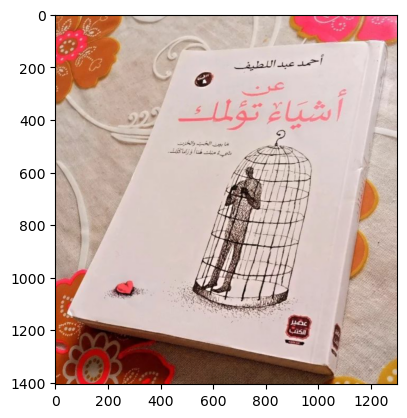

In [4]:
plt.imshow(Image.open(images_directories[0]))

In [5]:
print("Loading Annotations...")
annotations = []
for annotation_directory in tqdm(annotations_directories):
    with open(annotation_directory) as annotation_fh:
        annotations.append(json.load(annotation_fh))
print("Annotations Loaded")

print("Loading Images...")
images = []
for image_directory in tqdm(images_directories):
    images.append(Image.open(image_directory))
print("Images Loaded")

Loading Annotations...


100%|██████████| 840/840 [00:00<00:00, 3200.93it/s]


Annotations Loaded
Loading Images...


100%|██████████| 840/840 [00:00<00:00, 4385.67it/s]

Images Loaded


## Train-Validation-Test Splits

In [6]:
# Split the data into train, dev, and test sets
annotations_directories_train, annotations_directories_valtest, images_directories_train, images_directories_valtest = train_test_split(annotations_directories, images_directories, test_size=0.2, random_state=42)
annotations_directories_val, annotations_directories_test, images_directories_val, images_directories_test = train_test_split(annotations_directories_valtest, images_directories_valtest, test_size=0.5, random_state=42)

# Print the lengths of the splits
print("Train set size:", len(annotations_directories_train))
print("Dev set size:", len(annotations_directories_val))
print("Test set size:", len(annotations_directories_test))

Train set size: 672
Dev set size: 84
Test set size: 84


In [7]:
# Split the data into train, dev, and test sets
annotations_train, annotations_valtest, images_train, images_valtest = train_test_split(annotations, images, test_size=0.2, random_state=42)
annotations_val, annotations_test, images_val, images_test = train_test_split(annotations_valtest, images_valtest, test_size=0.5, random_state=42)

# Print the lengths of the splits
print("Train set size:", len(annotations_train))
print("Dev set size:", len(annotations_val))
print("Test set size:", len(annotations_test))

Train set size: 672
Dev set size: 84
Test set size: 84


## Helpers

In [8]:
class Helpers:
    @staticmethod
    def load_font() -> ImageFont:
        # Load a font
        try:
            font = ImageFont.truetype("Assets/Fonts/Amiri/Amiri-Regular.ttf", 15)
        except IOError:
            font = ImageFont.load_default()

        return font

    @staticmethod
    def load_colors_mapping() -> dict:
        labels = ['Body text', 'Title', 'Page']
        colors = ['blue', 'red', 'green']
        colors_mapping = {label:color for label, color in zip(labels, colors)}
        return colors_mapping

    @classmethod
    def draw_image_with_annotations(cls, image: Image, annotations: dict) -> None:
        font = cls.load_font()
        colors_mapping = cls.load_colors_mapping()
        draw = ImageDraw.Draw(image)

        # Draw the bounding boxes
        for obj in annotations['objects']:
            if obj['geometryType'] == 'rectangle':
                points = obj['points']['exterior']
                top_left = points[0]
                bottom_right = points[1]
                left = top_left[0]
                top = top_left[1]
                right = bottom_right[0]
                bottom = bottom_right[1]
                draw.rectangle([left, top, right, bottom], outline=colors_mapping[obj['classTitle']], width=2)
                draw.text((left, top - 20), obj['classTitle'], fill=colors_mapping[obj['classTitle']], font=font)
            elif obj['geometryType'] == 'polygon':
                points = obj['points']['exterior']
                flattened_points = [coord for point in points for coord in point]
                draw.polygon(flattened_points, outline=colors_mapping[obj['classTitle']])
                draw.text((flattened_points[0], flattened_points[1] - 15), obj['classTitle'], fill=colors_mapping[obj['classTitle']], font=font)

        # Display the image with bounding boxes
        plt.figure(figsize=(8, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        plt.close()

    @classmethod
    def normalize_bbox(cls, bbox: List[int], width: int, height: int) -> List[int]:
        return [
            int(1000 * (bbox[0] / width)),
            int(1000 * (bbox[1] / height)),
            int(1000 * (bbox[2] / width)),
            int(1000 * (bbox[3] / height)),
        ]

    @classmethod
    def generate_annotations(cls, annotations: List[dict]) -> Tuple[List[List[str]], List[List[List[int]]], List[List[str]]]:
        words = []
        boxes = []
        labels = []

        for annotation in tqdm(annotations):
            words_example = []
            boxes_example = []
            labels_example = []

            width, height = annotation['size']['width'], annotation['size']['height']
            # loop over OCR annotations
            for object in annotation['objects']:
                if object['geometryType'] == 'rectangle': # exclude 'polygon'
                    if object['tags']:
                        txt = object['tags'][0]['value'] # 'Title' case
                    else:
                        txt = '' # 'Body text' case

                    # get bounding box
                    points = object['points']['exterior']
                    top_left = points[0]
                    bottom_right = points[1]
                    left = top_left[0]
                    top = top_left[1]
                    right = bottom_right[0]
                    bottom = bottom_right[1]

                    box = [left, top, right, bottom]
                    box = cls.normalize_bbox(box, width=width, height=height)

                    # # skip empty word
                    # if len(txt) < 1: 
                    #     continue

                    if min(box) < 0 or max(box) > 1000: # validate min and max coordinate values
                        continue
                    if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0): # validate coordinates
                        continue

                    words_example.append(txt)
                    boxes_example.append(box) 
                    labels_example.append(object['classTitle'])
            words.append(words_example) 
            boxes.append(boxes_example)
            labels.append(labels_example)

        return words, boxes, labels

## Data Exploration

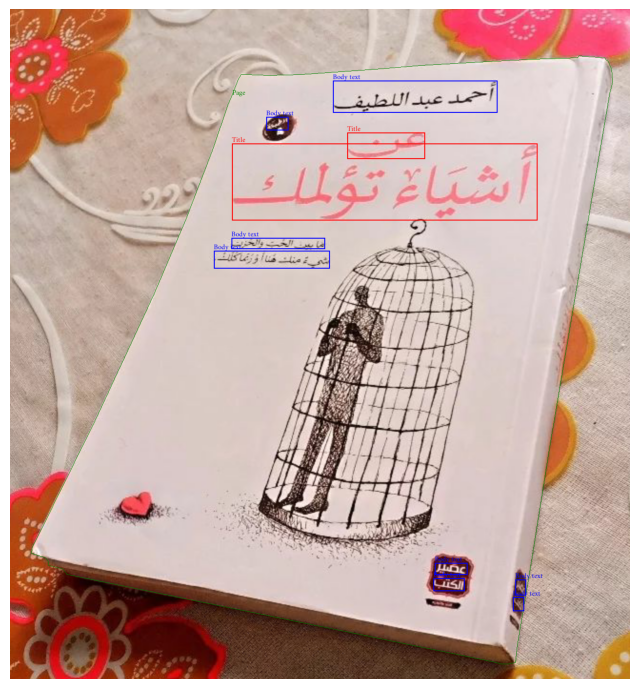

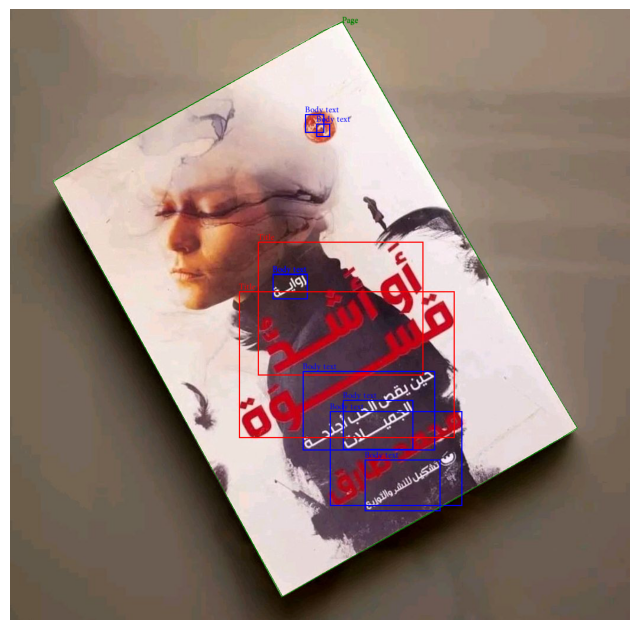

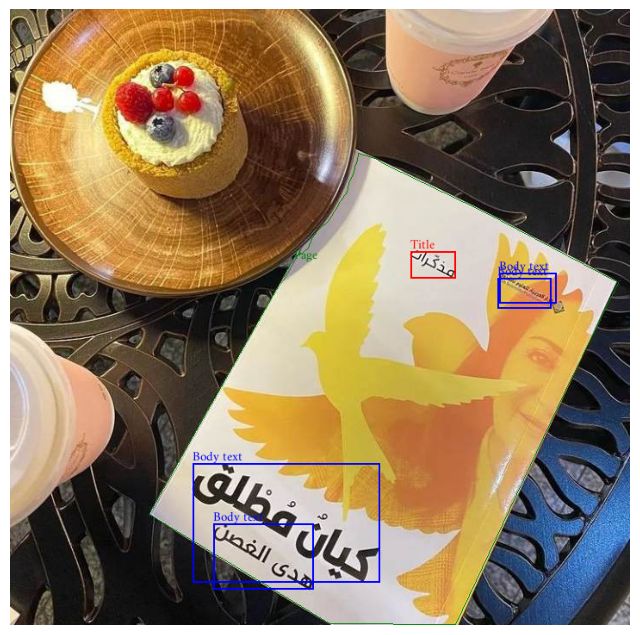

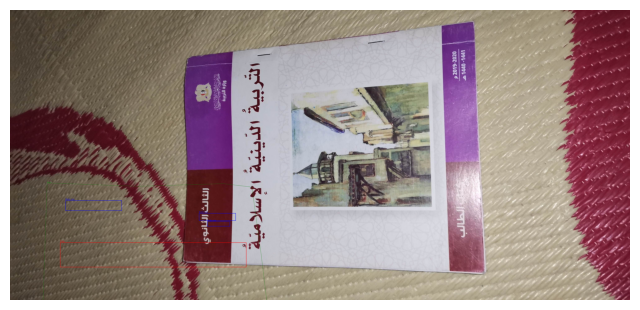

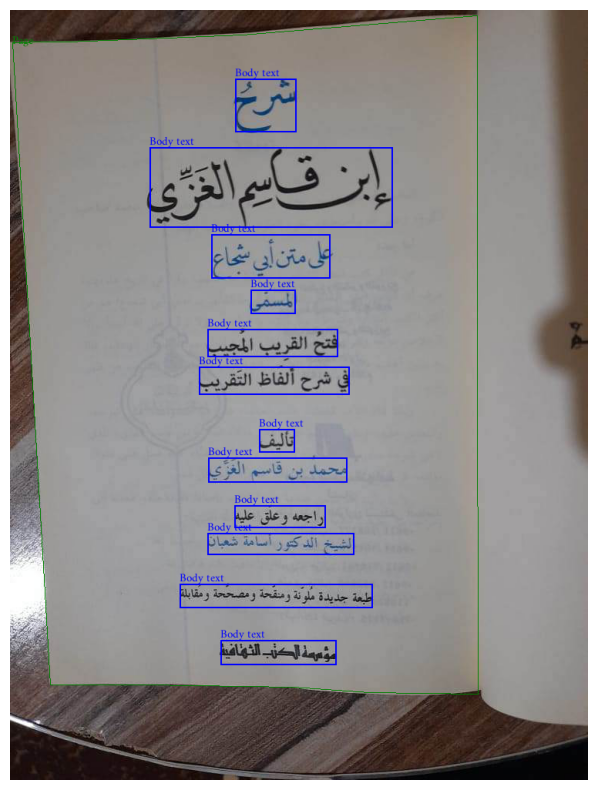

In [9]:
for i in range(5):
    Helpers.draw_image_with_annotations(images[i], annotations[i])

In [10]:
sample_annotation = annotations[0]
sample_object = sample_annotation['objects'][1]
sample_point = sample_object['points']['exterior']
left, top, right, bottom = sample_point[0][0], sample_point[0][1], sample_point[1][0], sample_point[1][1]

Helpers.normalize_bbox([left, top, right, bottom], annotations[0]['size']['width'], annotations[0]['size']['height'])

[520, 106, 785, 154]

## Data Preprocessing

In [11]:
words_train, boxes_train, labels_train = Helpers.generate_annotations(annotations_train)
words_val, boxes_val, labels_val = Helpers.generate_annotations(annotations_val)
words_test, boxes_test, labels_test = Helpers.generate_annotations(annotations_test)

100%|██████████| 84/84 [00:00<00:00, 92110.21it/s]


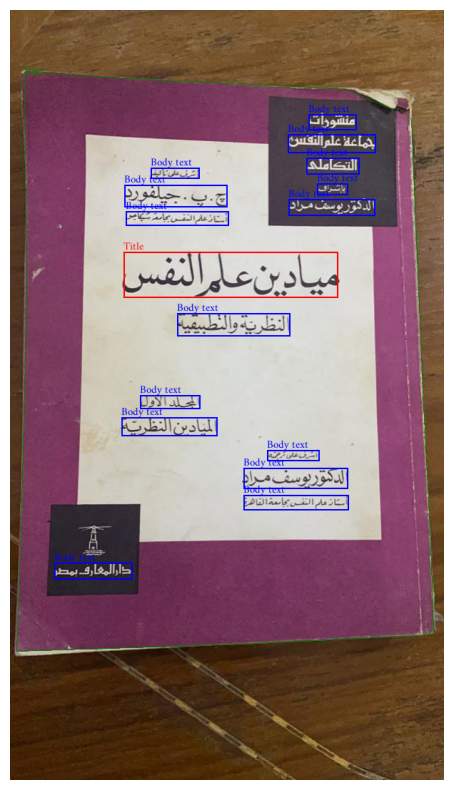

Word: ['ميادين علم النفس', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Boundary Boxes: [[261, 313, 754, 373], [324, 204, 435, 218], [263, 226, 500, 255], [266, 261, 503, 279], [641, 245, 840, 266], [707, 225, 777, 239], [682, 191, 804, 212], [639, 161, 842, 185], [687, 135, 797, 155], [384, 393, 644, 423], [299, 500, 437, 517], [256, 528, 476, 552], [592, 571, 712, 585], [537, 594, 777, 621], [537, 629, 779, 649], [101, 717, 281, 738]]
Labels: ['Title', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text']


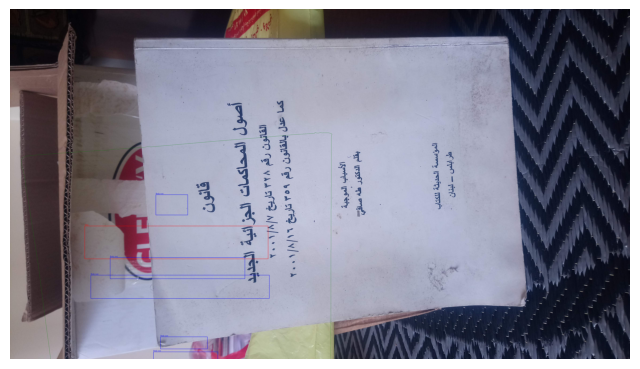

Word: ['أصول المحاكمات الجزائية الجديد', '', '', '', '', '', '', '']
Boundary Boxes: [[213, 349, 738, 402], [416, 299, 508, 331], [286, 400, 671, 434], [230, 428, 741, 466], [430, 528, 564, 547], [409, 552, 594, 574], [426, 679, 618, 697], [460, 702, 593, 719]]
Labels: ['Title', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text']


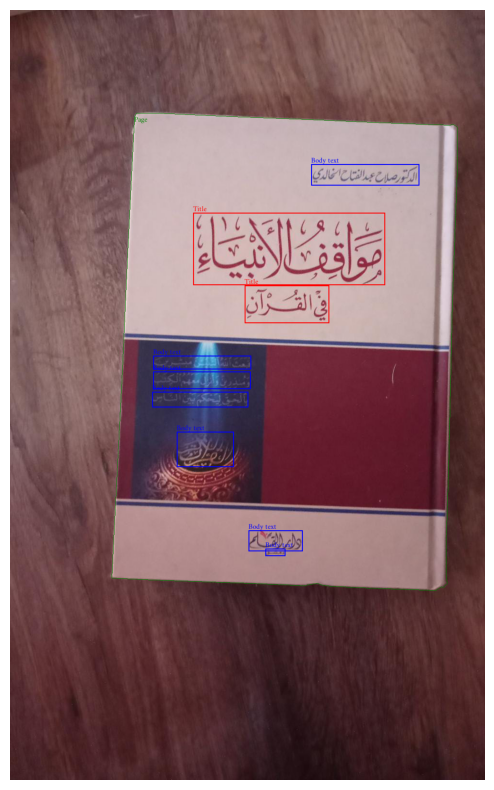

Word: ['مَواقفٌ الأنْبياءِ', 'في القٌرُآن', '', '', '', '', '', '', '']
Boundary Boxes: [[385, 263, 789, 356], [493, 357, 671, 406], [633, 200, 861, 227], [301, 448, 507, 466], [301, 469, 506, 491], [299, 495, 501, 515], [350, 547, 470, 593], [502, 675, 615, 702], [537, 699, 579, 708]]
Labels: ['Title', 'Title', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text']


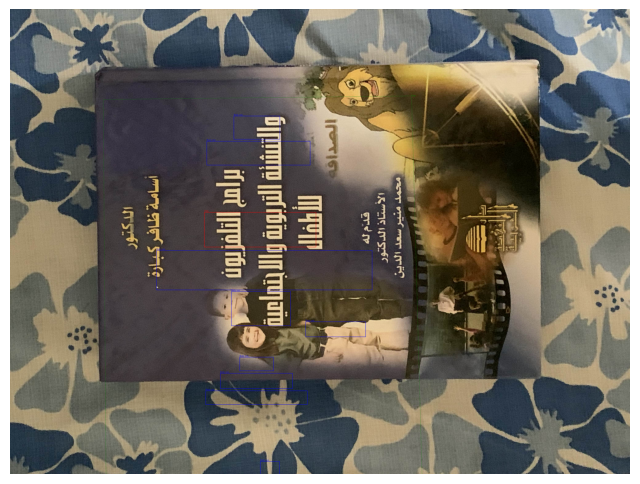

Word: ['', '', '', '', '', '', '', '', '', '', 'برامج التلفزيون', '']
Boundary Boxes: [[538, 729, 579, 771], [476, 769, 581, 798], [473, 771, 581, 825], [420, 615, 639, 637], [452, 587, 607, 612], [493, 561, 566, 583], [635, 504, 764, 528], [481, 172, 580, 210], [422, 213, 645, 251], [475, 455, 603, 510], [417, 327, 658, 383], [314, 389, 778, 453]]
Labels: ['Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Title', 'Body text']


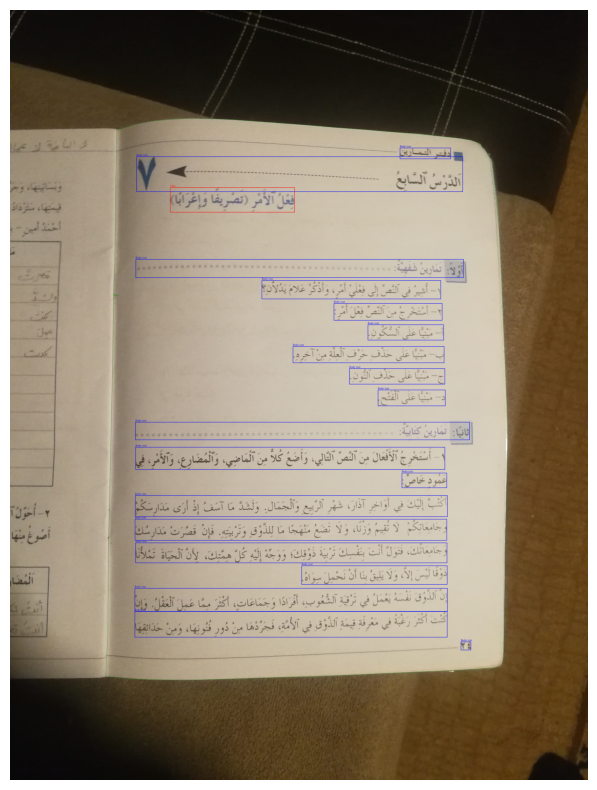

Word: ['', '', 'فِعْلُ اْلأَمْرِ (تَصْرِيفاً وَإِعْرَاباً)', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Boundary Boxes: [[674, 178, 762, 193], [218, 190, 783, 235], [276, 230, 492, 262], [217, 323, 784, 347], [435, 351, 745, 375], [560, 380, 747, 402], [618, 408, 750, 428], [489, 436, 751, 458], [587, 465, 752, 485], [636, 493, 753, 514], [216, 535, 795, 558], [217, 567, 752, 596], [677, 601, 755, 620], [216, 630, 756, 658], [216, 661, 755, 688], [217, 691, 756, 717], [504, 721, 756, 745], [215, 750, 756, 780], [215, 780, 756, 814], [779, 820, 797, 831]]
Labels: ['Body text', 'Body text', 'Title', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text', 'Body text']


In [12]:
for i in range(5):
    Helpers.draw_image_with_annotations(images_train[i], annotations_train[i])
    print("Word:", words_train[i])
    print("Boundary Boxes:", boxes_train[i])
    print("Labels:", labels_train[i])

## Saving LayoutLM Formatted Dataset

In [38]:
with open('LayoutLM_Formatted_Dataset/train.pkl', 'wb') as t:
    pickle.dump([words_train, labels_train, boxes_train], t)
with open('LayoutLM_Formatted_Dataset/dev.pkl', 'wb') as t:
    pickle.dump([words_val, labels_val, boxes_val], t)
with open('LayoutLM_Formatted_Dataset/test.pkl', 'wb') as t:
    pickle.dump([words_test, labels_test, boxes_test], t)

## Create Hugging Face Dataset

In [13]:
from datasets import Dataset, ClassLabel, Features, Sequence, Value, Image
from datasets import DatasetDict
from huggingface_hub import notebook_login

In [14]:
# Define the features
features = Features({
    'id': Value(dtype='string', id=None),
    'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
    'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
    'ner_tags': Sequence(feature=ClassLabel(names=['Title', 'Body text'], id=None), length=-1, id=None),
    # 'image': Value(dtype='string', id=None)  # Assuming you have paths to images
    'image': Image()
})

In [15]:
# Create the dataset
huggingface_train_dataset = Dataset.from_dict({
    'id': [str(i) for i in range(len(words_train))],  # Assuming unique IDs for each sample
    'words': words_train,
    'bboxes': boxes_train,
    'ner_tags': labels_train,
    'image': images_directories_train
}, features=features)

huggingface_validation_dataset = Dataset.from_dict({
    'id': [str(i) for i in range(len(words_val))],  # Assuming unique IDs for each sample
    'words': words_val,
    'bboxes': boxes_val,
    'ner_tags': labels_val,
    'image': images_directories_val
}, features=features)

huggingface_test_dataset = Dataset.from_dict({
    'id': [str(i) for i in range(len(words_test))],  # Assuming unique IDs for each sample
    'words': words_test,
    'bboxes': boxes_test,
    'ner_tags': labels_test,
    'image': images_directories_test
}, features=features)

In [16]:
# Create the dataset dictionary
huggingface_dataset = DatasetDict({
    'train': huggingface_train_dataset,
    'validation': huggingface_validation_dataset,
    'test': huggingface_test_dataset
})

# Print the keys and lengths of each split
print(huggingface_dataset.keys())
print("Train set size:", len(huggingface_dataset['train']))
print("Validation set size:", len(huggingface_dataset['validation']))
print("Test set size:", len(huggingface_dataset['test']))

dict_keys(['train', 'validation', 'test'])
Train set size: 672
Validation set size: 84
Test set size: 84


In [17]:
huggingface_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 672
    })
    validation: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 84
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 84
    })
})

In [18]:
huggingface_dataset['train'].features

{'id': Value(dtype='string', id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['Title', 'Body text'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None)}

0
['ميادين علم النفس', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[[261, 313, 754, 373], [324, 204, 435, 218], [263, 226, 500, 255], [266, 261, 503, 279], [641, 245, 840, 266], [707, 225, 777, 239], [682, 191, 804, 212], [639, 161, 842, 185], [687, 135, 797, 155], [384, 393, 644, 423], [299, 500, 437, 517], [256, 528, 476, 552], [592, 571, 712, 585], [537, 594, 777, 621], [537, 629, 779, 649], [101, 717, 281, 738]]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


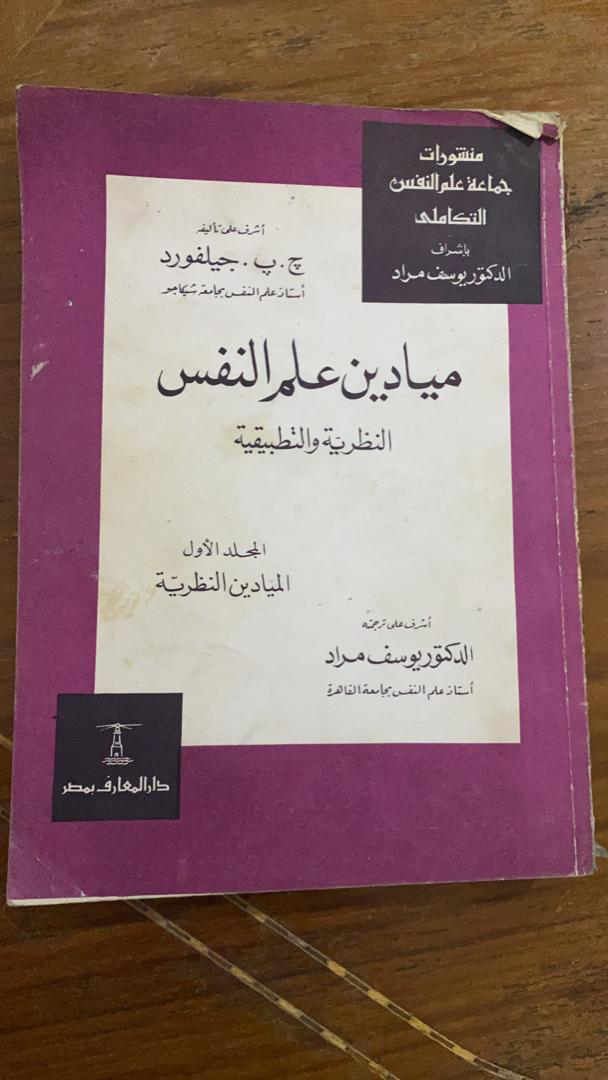

In [19]:
print(huggingface_dataset['train']['id'][0])
print(huggingface_dataset['train']['words'][0])
print(huggingface_dataset['train']['bboxes'][0])
print(huggingface_dataset['train']['ner_tags'][0])
huggingface_dataset['train']['image'][0]

## Push to Hugging Face Hub

In [92]:
notebook_login()

In [93]:
# Push the dataset to the Hugging Face Hub
huggingface_dataset.push_to_hub("alansary/arabic-books-layoutlm-formatted")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/84 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/84 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/alansary/arabic-books-layoutlm-formatted/commit/56f0f01e00ec2787f68a8672e13a4fad32c9b9e0', commit_message='Upload dataset', commit_description='', oid='56f0f01e00ec2787f68a8672e13a4fad32c9b9e0', pr_url=None, pr_revision=None, pr_num=None)